In [1]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.storages import RDBStorage

from sklearn.linear_model import LinearRegression

In [2]:
with open('configs/config.yaml','r') as file_object:
    config = yaml.load(file_object,Loader=yaml.SafeLoader)

In [3]:
study_dir = config['hpo']['studies_path']

font_size = 16

In [4]:
# get all studies
storage = RDBStorage(url=f"sqlite:///{study_dir}")
study_summaries = optuna.get_all_study_summaries(storage=storage)
study_names = []
for i, summary in enumerate(study_summaries):
    best_value = summary.best_trial.value if summary.best_trial is not None else "N/A"
    print(f"Study {i}: {summary.study_name}, Trials: {summary.n_trials}, Best Value: {best_value}")
    study_names.append(summary.study_name)
studies = [optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_dir}") for study_name in study_names]

Study 0: fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_pers, Trials: 27, Best Value: 0.08225551364208462
Study 1: fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h, Trials: 38, Best Value: 0.09771618896745958
Study 2: fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_gti_pers, Trials: 31, Best Value: 0.08525738747249116
Study 3: fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_gti, Trials: 26, Best Value: 0.09908610214949151
Study 4: fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h, Trials: 41, Best Value: 0.09837529219743828
Study 5: fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h_gti, Trials: 34, Best Value: 0.09966242999692125
Study 6: fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h_gti_pers, Trials: 126, Best Value: 0.08183429166889113
Study 7: fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h_pers, Trials: 164, Best Value: 0.08024186311691582
Study 8: cl_d-pvod_m-tcn-gru_out-48_freq-1h_incrfltrs-True, Trials: 21, Best Value: 0.020550549402832984
Study 9: cl_d-pvod_m-tcn-gru_out-48_freq-1h, Trials: 139, Best Value:

In [5]:
study = study_summaries[10].study_name
#optuna.delete_study(study_name=study, storage=f"sqlite:///{study_dir}")

### Best Trial

In [6]:
for study in study_summaries:
    print(f'Best trial of {study.study_name}')
    trial = study.best_trial
    if not trial:
        print('No best trial for this.')
        continue
    print(f'  Error: {trial.value}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    print()

Best trial of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_pers
  Error: 0.08225551364208462
  Params: 
    batch_size: 45
    epochs: 10
    lr: 0.0008657474485291862
    n_rounds: 30
    filters: 31
    kernel_size: 3
    n_cnn_layers: 5
    units: 102
    n_rnn_layers: 3

Best trial of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h
  Error: 0.09771618896745958
  Params: 
    batch_size: 87
    epochs: 18
    lr: 0.0006109480411664502
    n_rounds: 28
    filters: 39
    kernel_size: 2
    n_cnn_layers: 1
    units: 203
    n_rnn_layers: 3

Best trial of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_gti_pers
  Error: 0.08525738747249116
  Params: 
    batch_size: 135
    epochs: 31
    lr: 0.0002389713574364091
    n_rounds: 28
    filters: 34
    kernel_size: 3
    n_cnn_layers: 5
    units: 251
    n_rnn_layers: 2

Best trial of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_gti
  Error: 0.09908610214949151
  Params: 
    batch_size: 68
    epochs: 39
    lr: 0.0012230975691669094
    n_rou

In [7]:
def ten_best(study):
    trials = [trial for trial in study.trials if trial.value is not None]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    print("Top 10 Trials:", '\n')
    for trial in sorted_trials[:10]:
        print(f"Trial {trial.number}: MAE = {trial.value}")
        print(f"  Params: {trial.params}")
        print()

HPO Progess of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_pers
Improvement per Trial: 0.00543858047601917


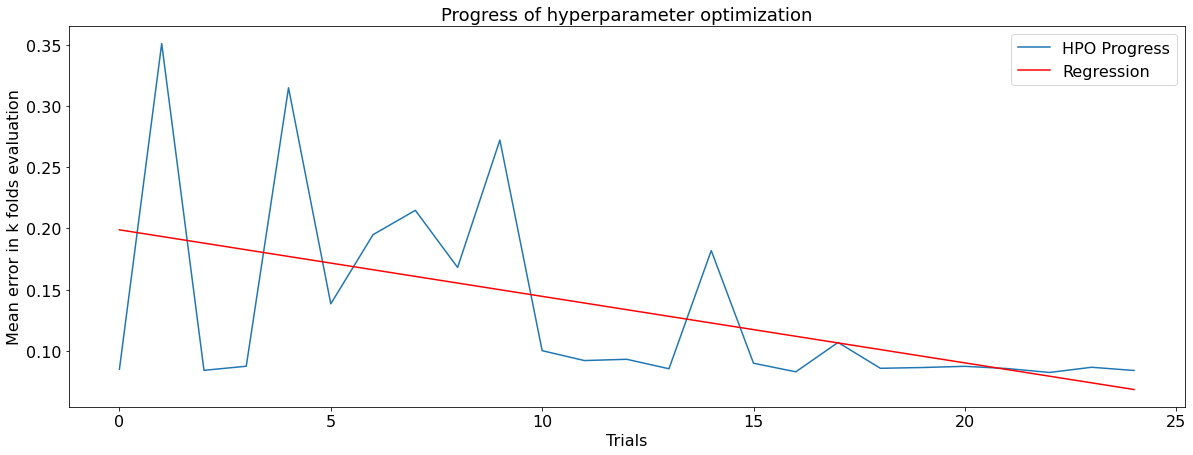

HPO Progess of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h
Improvement per Trial: 0.003818398958585196


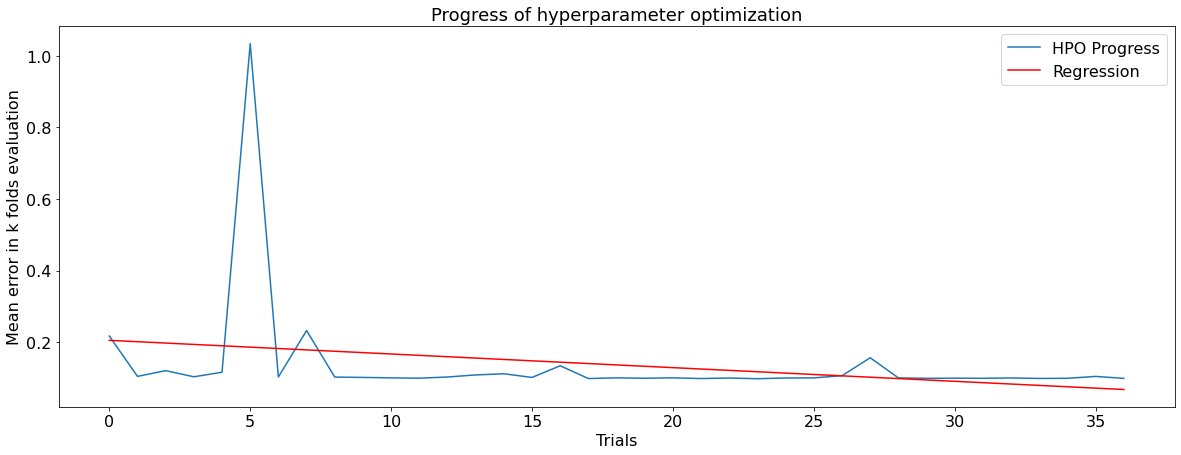

HPO Progess of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_gti_pers
Improvement per Trial: 0.004995579408264376


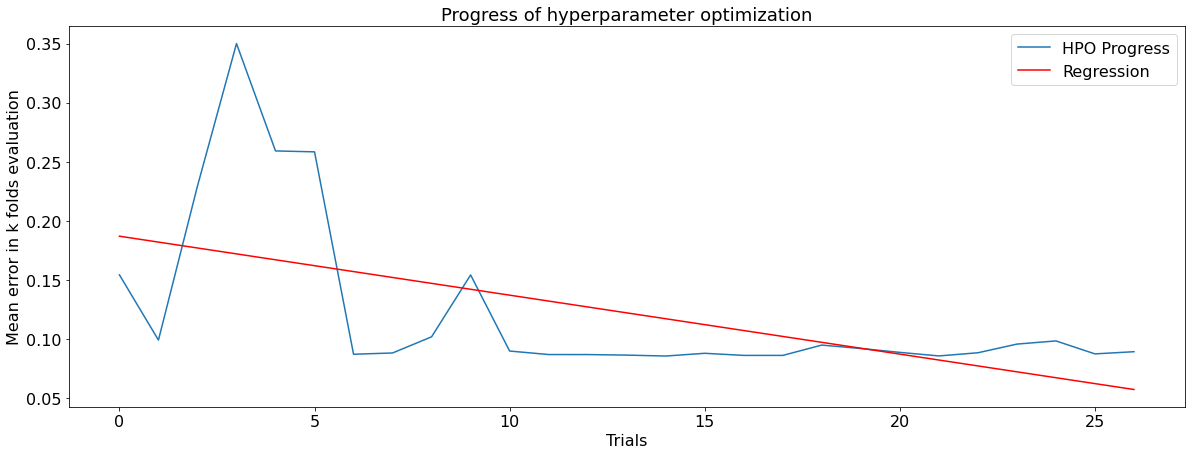

HPO Progess of fl_a-fedavg_d-pvod_m-tcn-gru_out-48_freq-1h_gti
Improvement per Trial: 0.0029037341148970787


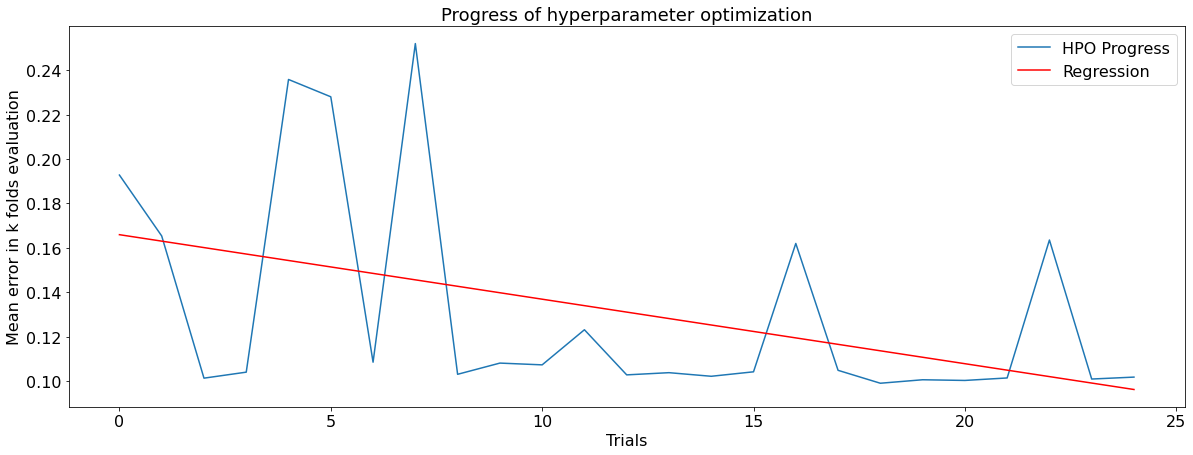

HPO Progess of fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h
Improvement per Trial: 0.0035014252131636246


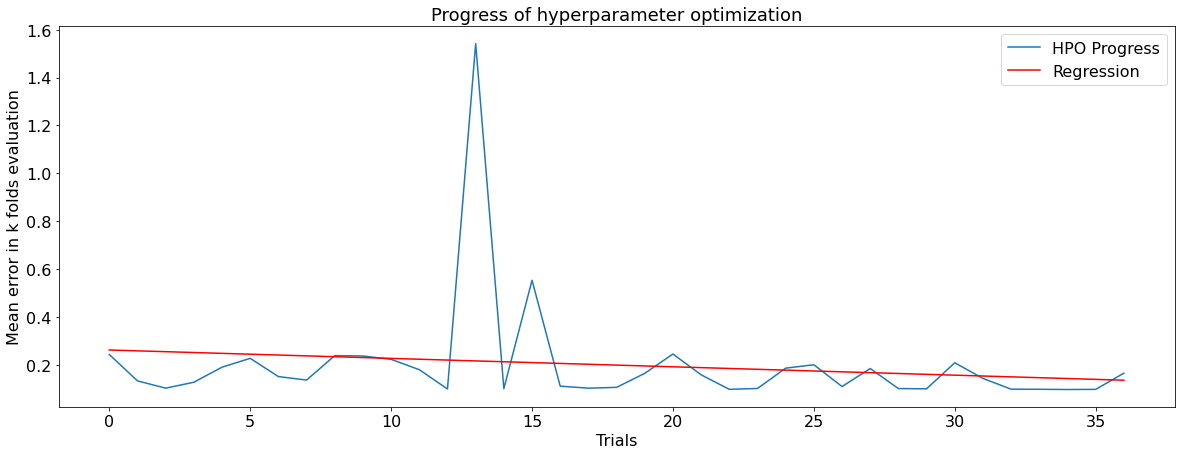

HPO Progess of fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h_gti
Improvement per Trial: 0.004840975124868582


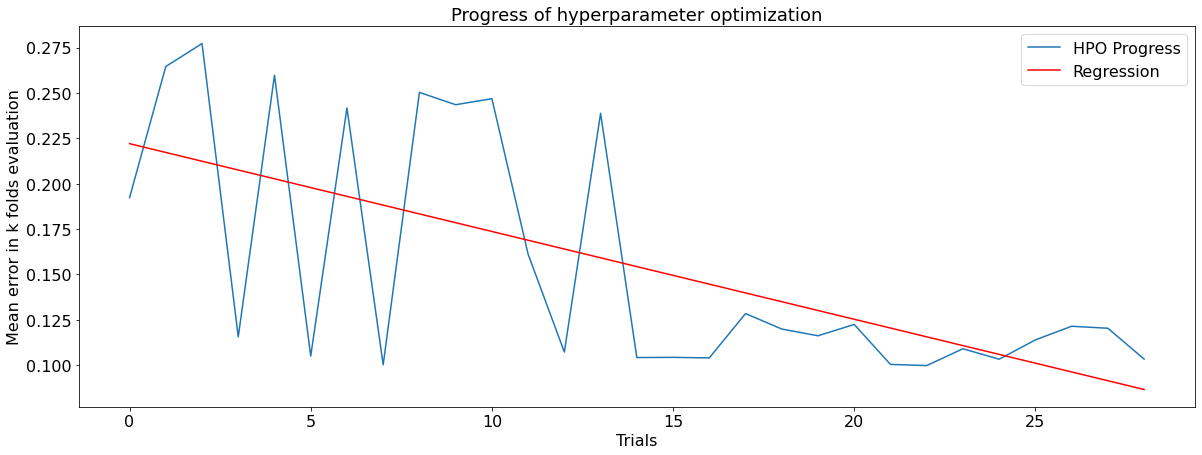

HPO Progess of fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h_gti_pers
Improvement per Trial: 0.0006158742267837701


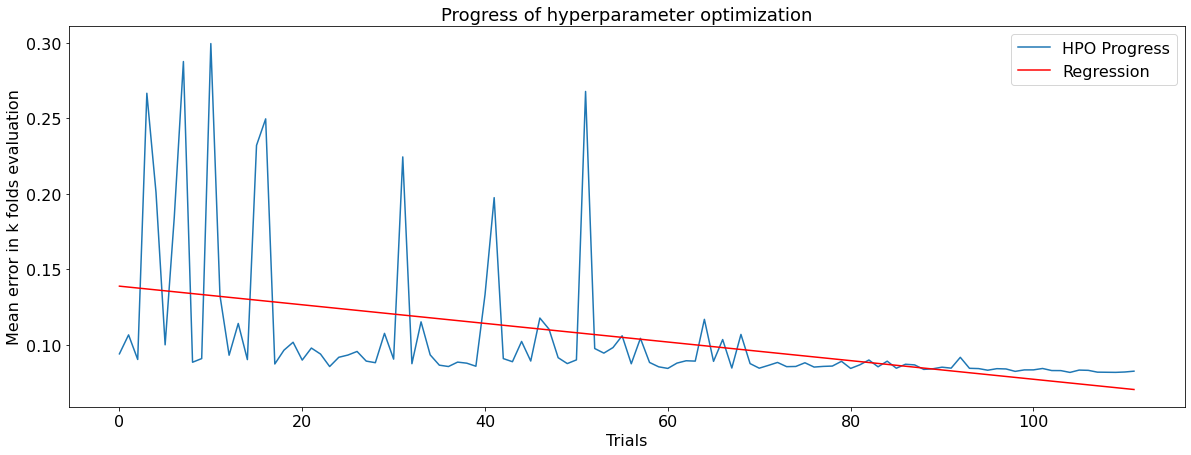

HPO Progess of fl_a-fedadam_d-pvod_m-tcn-gru_out-48_freq-1h_pers
Improvement per Trial: 0.000282355976120818


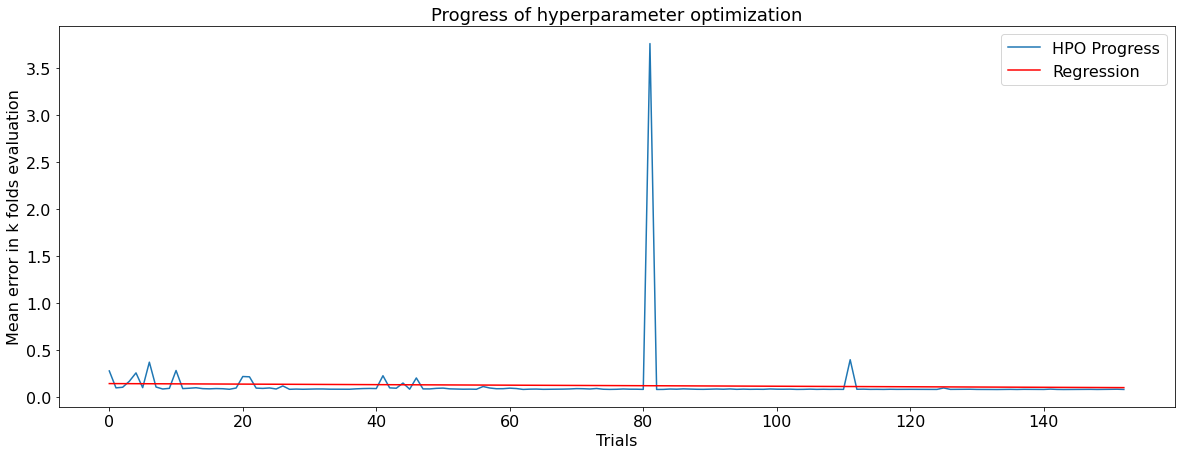

HPO Progess of cl_d-pvod_m-tcn-gru_out-48_freq-1h_incrfltrs-True
Improvement per Trial: 0.0026358639416203173


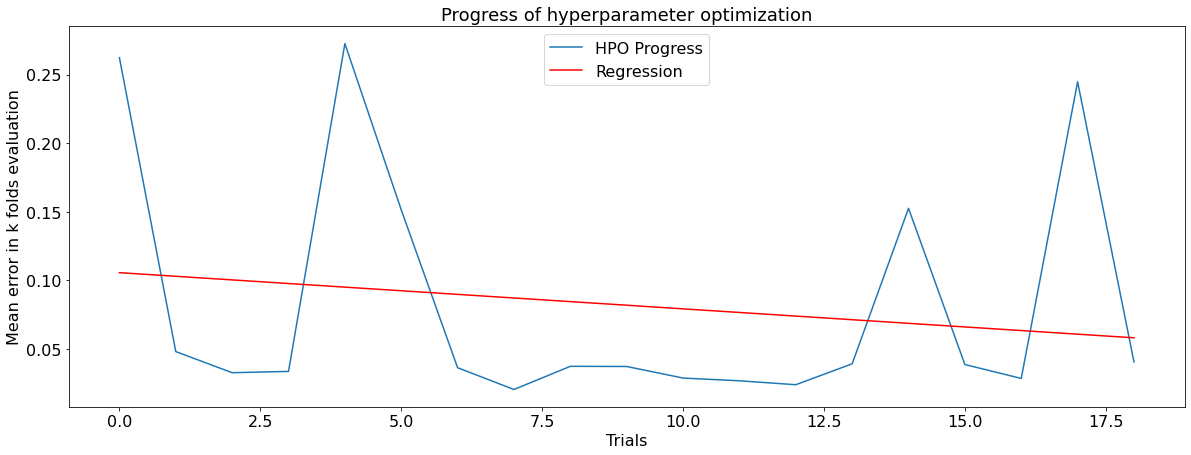

HPO Progess of cl_d-pvod_m-tcn-gru_out-48_freq-1h
Improvement per Trial: 0.0005603300180078321


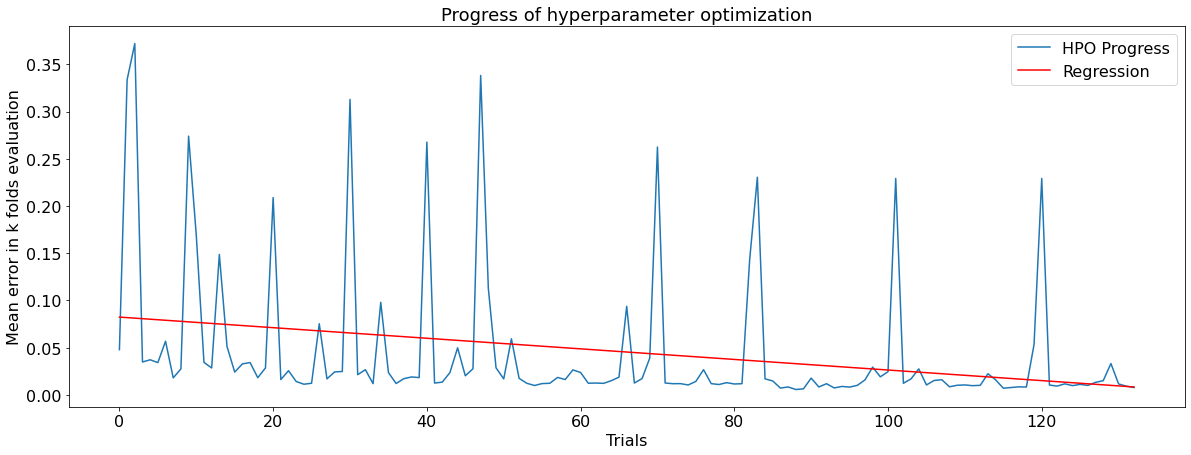

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_00164
Improvement per Trial: 0.00013479734061185781


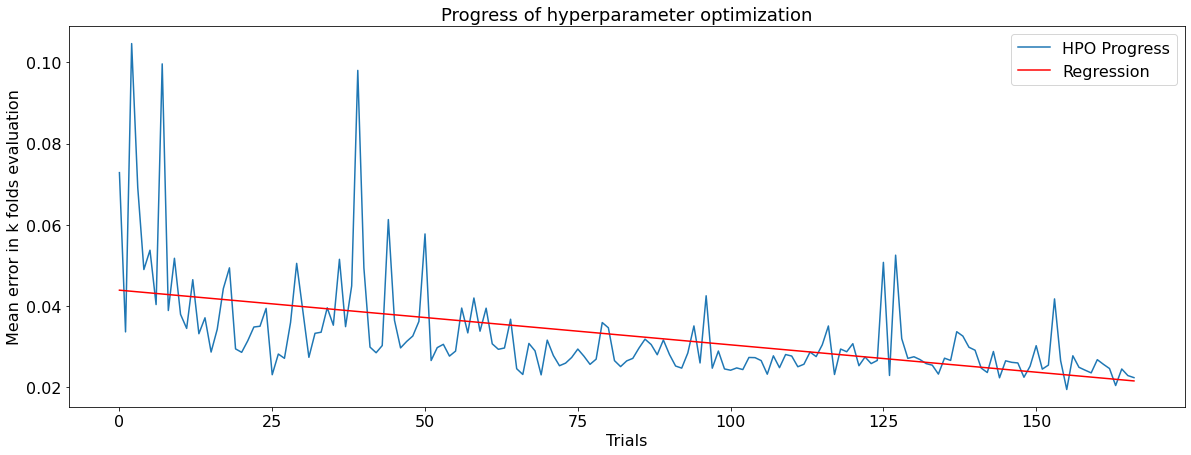

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_03362
Improvement per Trial: 0.002485697716474534


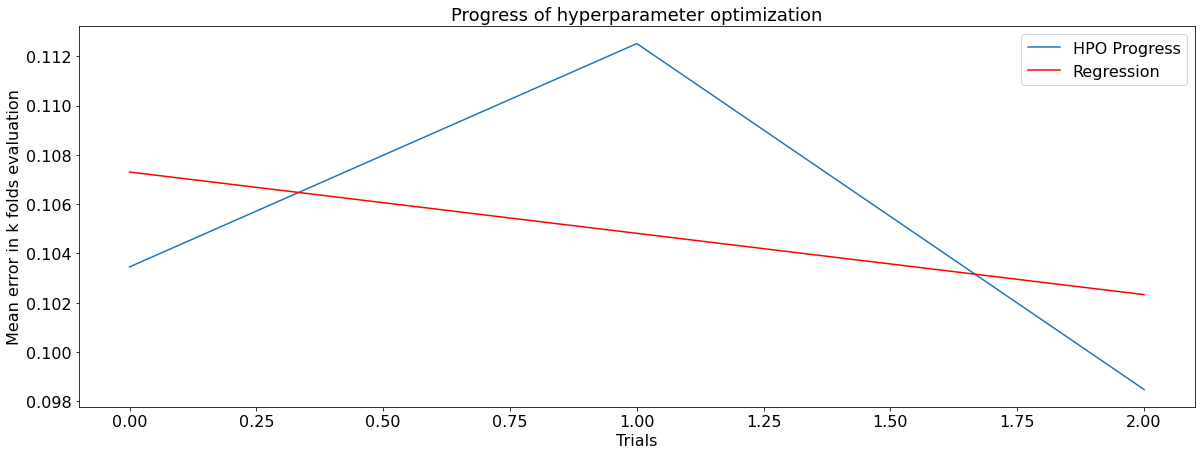

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_03631
Improvement per Trial: 0.0005669930548378426


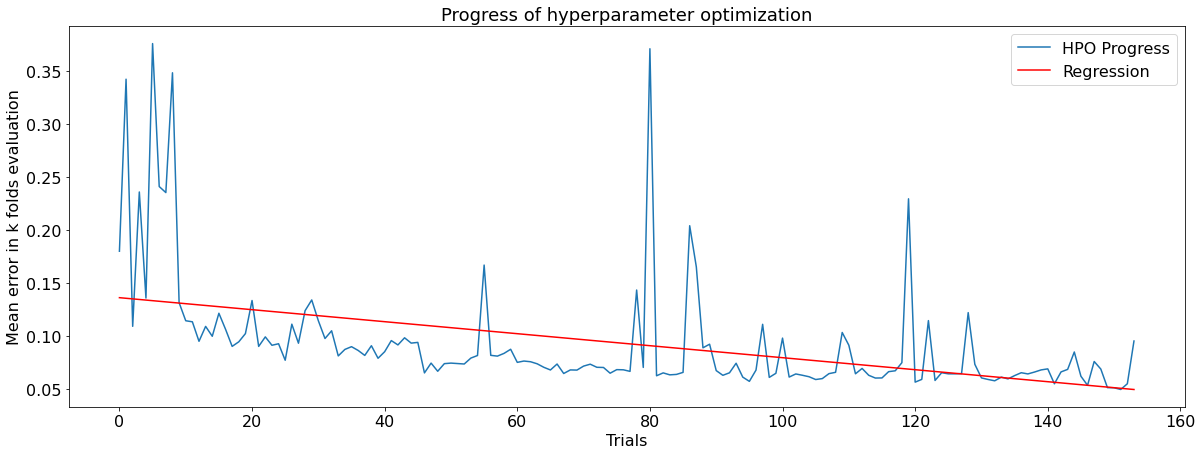

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_07370
Improvement per Trial: 0.0013023914952882743


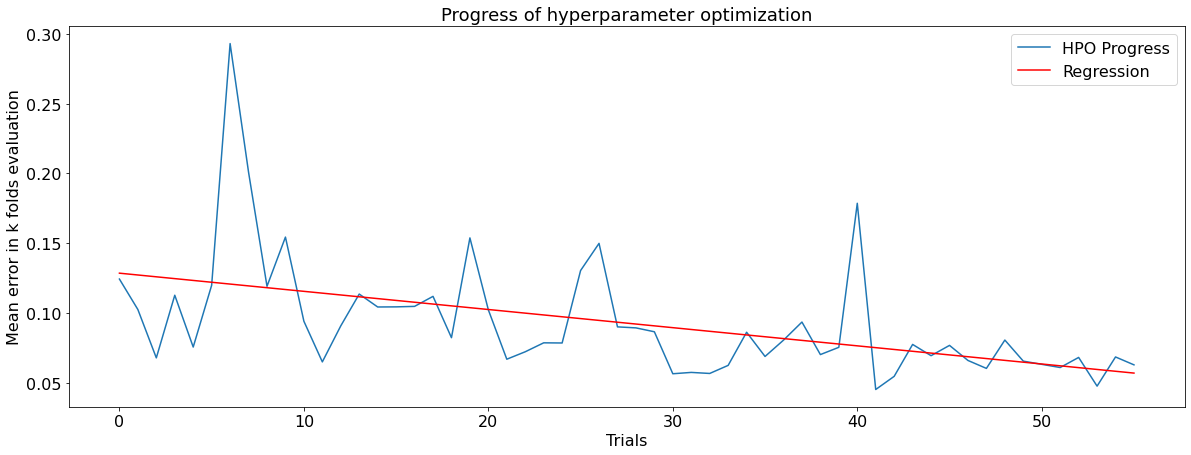

HPO Progess of cl_m-tft_out-48_freq-1h
Improvement per Trial: 0.0033451429880284635


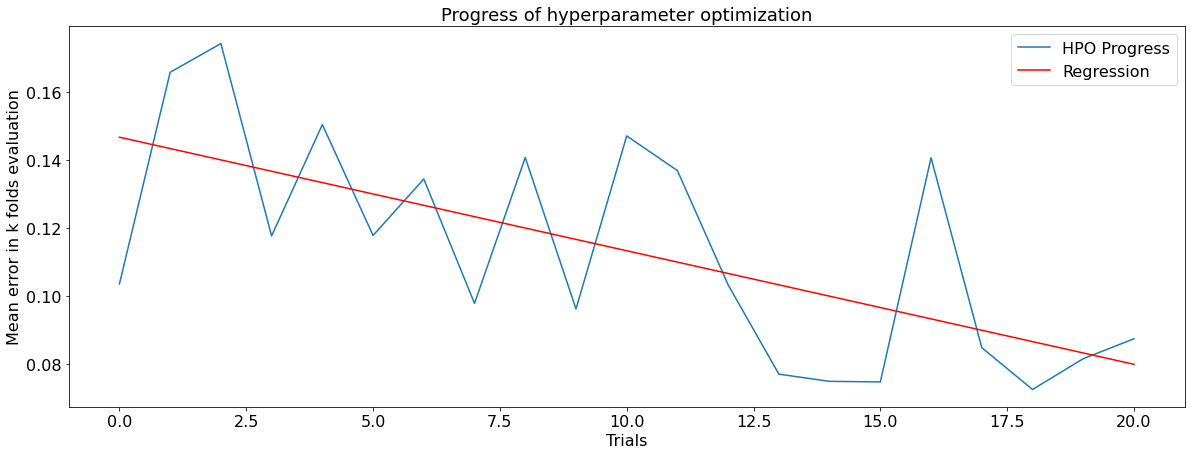

In [8]:
for study in studies:
    print(f'HPO Progess of {study.study_name}')
    trials = [trial for trial in study.trials if trial.value is not None]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    sorted_by_number = sorted(trials, key=lambda x: x.number)
    progress = [trial.values for trial in sorted_by_number]
    x = np.arange(len(progress)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, progress)
    y_pred = lr.predict(x)
    plt.figure(figsize=(20,7))
    print('Improvement per Trial:', lr.coef_[0][0]*-1)
    plt.plot(progress, label='HPO Progress')
    plt.plot(y_pred, 'r-', label='Regression')
    plt.title('Progress of hyperparameter optimization', fontsize=font_size+2)
    plt.xlabel('Trials', fontsize=font_size)
    plt.ylabel('Mean error in k folds evaluation', fontsize=font_size)
    ax = plt.gca()  # Get current axes
    ax.tick_params(axis='x', labelsize=font_size)  # Schriftgröße für x-Achsenmarkierungen
    ax.tick_params(axis='y', labelsize=font_size)
    #plt.yticks(np.arange(0,1,0.1))
    #plt.ylim(0,0.6)
    plt.legend(fontsize=font_size)
    plt.show()